In [1]:
import sys
print(sys.executable)
import os
import sys
if os.getcwd().endswith('visualize'):
    os.chdir('..')
sys.path.append(os.getcwd())


/usr/bin/python


In [ ]:
import os
import sys
if os.getcwd().endswith('visualize'):
    os.chdir('..')
sys.path.append(os.getcwd())
from loader.dataloader import VideoDataSet,VideoDataLoader
import torch


dataset ="50salads"
split_test = "test.split2.bundle"
split_train = "train.split2.bundle"

default_path="./data/data/"

knowns = ["cut_tomato",
          "place_tomato_into_bowl",

          "place_cheese_into_bowl",
          "cut_lettuce",

          "add_salt",

          "add_pepper",

          "peel_cucumber",
          "cut_cucumber",
          "place_cucumber_into_bowl",
          "add_dressing",

          "serve_salad_onto_plate",
          "action_start",
          "action_end",
          ]
unknowns = [
    "add_vinegar",
    "add_oil",
    "cut_cheese",
    "mix_dressing",
    "place_lettuce_into_bowl",
    "mix_ingredients",
]

knowns = ["cut_tomato",
         
          "cut_lettuce",

        

          "peel_cucumber",
          "cut_cucumber",
          "place_cucumber_into_bowl",
          "add_dressing",

          "serve_salad_onto_plate",
          "action_start",
          "action_end",
               "place_tomato_into_bowl",

          "place_cheese_into_bowl",
          
     "add_salt",

     "add_pepper",
          ]
unknowns = [
    "add_vinegar",
    "add_oil",
    "cut_cheese",
    "mix_dressing",
    "place_lettuce_into_bowl",
    "mix_ingredients",
    

          
]

hold_outs = [
  
]

video_dataset_test = VideoDataSet(dataset=dataset,
                               split=split_test,
                               default_path=default_path,
                               knowns=knowns,
                               unknowns=unknowns,
                               holdout_set = hold_outs
                             )
data_loader_test = VideoDataLoader(video_dataset_test, batch_size=1, shuffle=True)

video_dataset_train = VideoDataSet(dataset=dataset,
                               split=split_train,
                               default_path=default_path,
                               knowns=knowns,
                               unknowns=unknowns,
                                holdout_set = hold_outs
                              )
data_loader_train = VideoDataLoader(video_dataset_train, batch_size=1, shuffle=False)

In [4]:
from model.bert import ActionBERT, ActionBERTConfig
import torch.nn.functional as F
from model.boundary_model import ActionBoundary

train_for_knowns = True

bert_conf = ActionBERTConfig(
    known_classes=knowns,
    input_dim=2048,
    d_model=128,
    num_heads=4,
    num_layers=8,
    local_window_size=128,
    window_dilation=32,
    dropout=0)
model = ActionBoundary(config=bert_conf, train_for_knowns=train_for_knowns)

path = "./output/ssad_holdouts_try.pth"

state_dict = torch.load(path, map_location=torch.device('cuda'))
model.load_state_dict(state_dict, strict=False)
model = model.to('cuda')
model.eval()
print("Modell erfolgreich geladen.")

def get_model_pred(features,padding_mask):
    unknown_mask = torch.zeros_like(padding_mask).bool()
    res  = model(features,padding_mask)
       
    return res
 

/tmp/ipykernel_9638/3193063651.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.device('cuda'))


Modell erfolgreich geladen.


In [5]:
i = 0
for batch_test in data_loader_train:
    features = batch_test["features"]
    unknown_mask = batch_test["unknown_mask"]
    target_truth = batch_test["target_truth"]
    padding_mask = batch_test["padding_mask"]
    labels_dict = batch_test["labels_dict"]
    remap_dict = batch_test["remap_dict"]
    target_start = batch_test['target_start']
    target_end = batch_test['target_end']
   
    if i == 3:
        break
    i +=1
   
    
    
for batch_train in data_loader_train:

   
   
   
   
    
    break

torch.Size([4552, 128])
torch.Size([1, 12585]) torch.Size([1, 12585])
Klassen im Train-Ausschnitt: [ 0  1  2  3  4  5  6  7  8 15 17 18]
Klassen im Test-Ausschnitt:  [ 0  1  2  3  4  5  6  7  8 15 17 18]


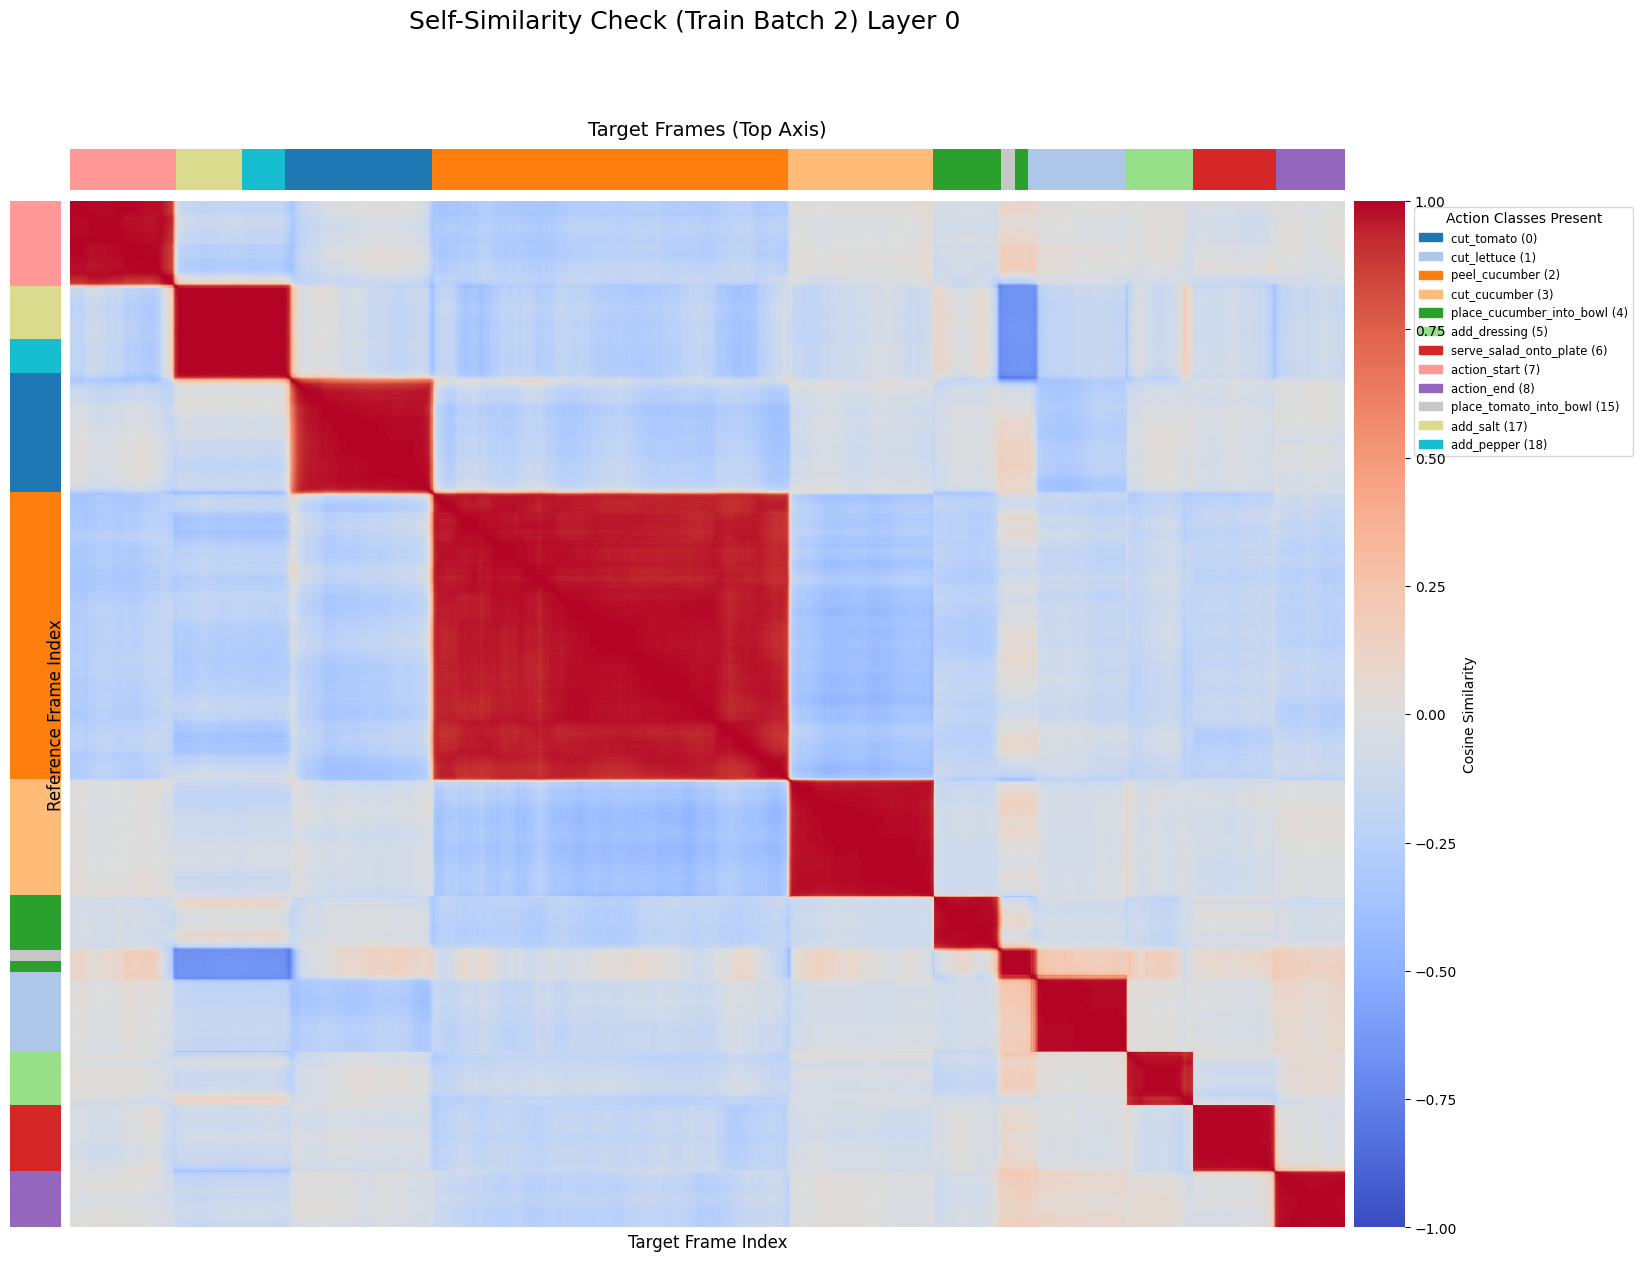

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import ListedColormap

# --- 1. HELPER: FARBEN & NAMEN SELBST GENERIEREN ---
def generate_color_resources(labels_dict):
    """
    Erstellt color_lut und id_to_name basierend auf dem labels_dict,
    damit wir keine Abhängigkeiten zu vorherigen Zellen haben.
    """
    # 1. ID zu Name Mapping
    # Fallback, falls labels_dict None ist
    if labels_dict is None:
        # Wir nehmen an, IDs gehen bis 100
        id_to_name = {i: f"Class {i}" for i in range(100)}
        max_id = 100
    else:
        id_to_name = {v: k for k, v in labels_dict.items()}
        max_id = max(labels_dict.values()) if labels_dict else 0
    
    # 2. Farben generieren (Mix aus Tab20, Set3 und Jet für viele Klassen)
    c1 = plt.get_cmap('tab20').colors
    c2 = plt.get_cmap('Set3').colors
    
    # Jet für den Rest (kontinuierlich)
    cmap_jet = plt.get_cmap('jet')
    c3 = cmap_jet(np.linspace(0, 1, 30))[:, :3] # Nur RGB nehmen
    
    base_colors = np.vstack((c1, c2, c3))
    
    # Sicherstellen, dass wir genug Farben haben
    while len(base_colors) <= max_id + 5:
        base_colors = np.vstack((base_colors, base_colors))
        
    color_lut = base_colors.copy()
    
    # Spezialfarben definieren (für Masking am Ende der Liste)
    BLACK_ID = len(color_lut) - 1
    color_lut[BLACK_ID] = [0.0, 0.0, 0.0] # Schwarz für Masked/Padding
    
    return color_lut, id_to_name, BLACK_ID

# --- 2. DATEN EXTRAKTION ---
def get_alignment_data(model, train_batch, test_batch, device, num_frames=2000,layer_id=0):
    """
    Inferiert Embeddings für ein Train- und ein Test-Video und berechnet die Ähnlichkeit.
    """
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        # Fenster definieren (Startpunkte)
        start_one = 0
        start_two = 0
        
        # Forward Pass
        # Wir übergeben None für target_truth im Forward, da wir nur Features wollen
        # (Annahme: dein Model forward Signatur ist (features, target, padding_mask))
        known_mask_train = torch.ones_like(train_batch["unknown_mask"]).bool()
        features_train = train_batch["features"][known_mask_train].to("cuda").unsqueeze(0)
        padding_mask_train =  train_batch["padding_mask"][known_mask_train].to("cuda").unsqueeze(0)
        
        known_mask_test = torch.ones_like(test_batch["unknown_mask"]).bool()
        features_test = test_batch["features"][known_mask_test].to("cuda").unsqueeze(0)
        padding_mask_test =  test_batch["padding_mask"][known_mask_test].to("cuda").unsqueeze(0)
        
        """ # --- TRAIN BATCH ---
        # 1. Filter-Maske: Knowns ODER Holdouts behalten
        known_mask_train = (~train_batch["unknown_mask"] | train_batch["holdout_mask"])

        # 2. Daten filtern, auf GPU, Batch-Dimension [1, T, D]
        features_train = train_batch["features"][known_mask_train].to("cuda").unsqueeze(0)
        padding_mask_train = train_batch["padding_mask"][known_mask_train].to("cuda").unsqueeze(0)

        # Falls du die unknown_mask für das Model brauchst (Holdouts = neue Unknowns):
        # unknown_mask_train = train_batch["holdout_mask"][keep_mask_train].to("cuda").unsqueeze(0)


        # --- TEST BATCH ---
        # 1. Filter-Maske
        known_mask_test = (~test_batch["unknown_mask"] | test_batch["holdout_mask"])

        # 2. Daten filtern
        features_test = test_batch["features"][known_mask_test].to("cuda").unsqueeze(0)
        padding_mask_test = test_batch["padding_mask"][known_mask_test].to("cuda").unsqueeze(0)

        # Falls benötigt:
        # unknown_mask_test = test_batch["holdout_mask"][keep_mask_test].to("cuda").unsqueeze(0) """

        out_train = model(features_train, padding_mask_train)
        out_test = model(features_test, padding_mask_test)

        # Embeddings extrahieren
        # Zugriffsschlüssel kann variieren je nach Model Output Dictionary (z.B. "embeddings" oder "features")
        raw_train = out_train["embeddings"][layer_id].squeeze(0)[::2,:] # [T_total, Dim]
        raw_test = out_test["embeddings"][layer_id].squeeze(0)[::2,:] 

        # --- CENTERING / NORMALIZATION ---
        # Hier nehmen wir die rohen Daten (oder du aktivierst das Centering wieder)
        print(raw_train.shape)
        proc_train = raw_train
        proc_test = raw_test
        
        # Optional: Global Centering (oft gut für Cosine Sim)
        proc_train = proc_train - proc_train.mean(dim=0, keepdim=True)
        proc_test = proc_test - proc_test.mean(dim=0, keepdim=True)

        # Slicing: Sicherstellen, dass wir nicht über die Länge hinausgehen
        len_train = min(num_frames, proc_train.shape[0] - start_one)
        len_test = min(num_frames, proc_test.shape[0] - start_two)
        
        slice_train = proc_train[start_one : start_one + len_train]
        slice_test = proc_test[start_two : start_two + len_test]

        # L2-Normalisierung für Cosine Similarity (wichtig für Heatmap -1 bis 1)
        emb_train = F.normalize(slice_train, p=2, dim=-1)
        emb_test = F.normalize(slice_test, p=2, dim=-1)
        
        # Ground Truth Labels slicen
        print(train_batch["target_truth"].shape,known_mask_train.shape)
        gt_train =  train_batch["target_truth"][known_mask_train][::2]
        gt_test = test_batch["target_truth"][known_mask_test][::2]
        gt_train = gt_train[ start_one : start_one + len_train].cpu().numpy()
        gt_test = gt_test[start_two : start_two + len_test].cpu().numpy()
        
        print("Klassen im Train-Ausschnitt:", np.unique(gt_train))
        print("Klassen im Test-Ausschnitt: ", np.unique(gt_test))

    # Similarity Matrix: (N_train x N_test)
    similarity_matrix = torch.matmul(emb_train, emb_test.t()).cpu().numpy()

    return similarity_matrix, gt_train, gt_test

# --- 3. PLOTTING ---
def plot_alignment_matrix(similarity_matrix, gt_train, gt_test, labels_dict, title="Cross-Domain Affinity"):
    
    # HIER: Farben und Namen lokal generieren -> Keine externe Dependency
    color_lut, id_to_name, BLACK_ID = generate_color_resources(labels_dict)
    
    fig = plt.figure(figsize=(18, 14))
    
    # Grid: [Links-Labels (schmal), Heatmap (breit), Colorbar (schmal)]
    gs = plt.GridSpec(2, 3, 
                      width_ratios=[1, 25, 1], 
                      height_ratios=[1, 25], 
                      hspace=0.02, wspace=0.02)

    ax_top = fig.add_subplot(gs[0, 1])
    ax_left = fig.add_subplot(gs[1, 0])
    ax_main = fig.add_subplot(gs[1, 1], sharex=ax_top, sharey=ax_left)
    ax_cbar = fig.add_subplot(gs[1, 2])

    # Colormap für die Label-Bars erstellen
    # Wir müssen sicherstellen, dass die Indizes der Labels auf die richtigen Farben mappen
    custom_cmap = ListedColormap(color_lut)
    v_min = 0
    v_max = len(color_lut) - 1

    # A. Test-Labels (Oben - Horizontal)
    # gt_test[None, :] macht aus (N,) ein (1, N) Array für imshow
    ax_top.imshow(gt_test[None, :], aspect='auto', cmap=custom_cmap, 
                  interpolation='nearest', vmin=v_min, vmax=v_max)
    ax_top.set_axis_off()
    ax_top.set_title("Target Frames (Top Axis)", fontsize=14, pad=10)

    # B. Train-Labels (Links - Vertikal)
    # gt_train[:, None] macht aus (N,) ein (N, 1) Array
    ax_left.imshow(gt_train[:, None], aspect='auto', cmap=custom_cmap, 
                   interpolation='nearest', vmin=v_min, vmax=v_max)
    ax_left.set_axis_off()
    ax_left.set_ylabel("Reference Frames (Left Axis)", fontsize=12)

    # C. Haupt-Heatmap
    # vlag oder coolwarm sind gut für -1 bis 1 (blau=negativ, rot=positiv)
    sns.heatmap(similarity_matrix, ax=ax_main, cmap='coolwarm', center=0.0, 
                vmin=-1, vmax=1.0, cbar_ax=ax_cbar, 
                cbar_kws={'label': 'Cosine Similarity'})
    
    ax_main.set_xlabel("Target Frame Index", fontsize=12)
    ax_main.set_ylabel("Reference Frame Index", fontsize=12)
    ax_main.set_xticks([]) # Zu viele Ticks entfernen
    ax_main.set_yticks([])

    # D. Legende
    patches = []
    # Welche IDs kommen in diesen beiden Ausschnitten wirklich vor?
    present_ids = np.unique(np.concatenate([gt_train, gt_test]))
    
    for uid in sorted(present_ids):
        uid_int = int(uid)
        
        # Name ermitteln
        if uid_int in id_to_name:
            label_text = f"{id_to_name[uid_int]} ({uid_int})"
        elif uid_int == BLACK_ID:
            label_text = "Masked/Pad"
        else:
            label_text = f"Cluster/Unknown {uid_int}"
        
        # Schutz gegen Out-of-Bounds bei Farben
        if uid_int < len(color_lut):
            color = color_lut[uid_int]
        else:
            color = [0,0,0] # Fallback Schwarz
            
        patches.append(mpatches.Patch(color=color, label=label_text))

    # Legende platzieren (oben links außerhalb oder rechts)
    ax_main.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc='upper left', 
                   fontsize='small', title="Action Classes Present")

    plt.suptitle(title, fontsize=18, y=0.98)
    plt.show()

# --- 4. AUSFÜHRUNG ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


for layer_id in range(0,6):
    # Iterator holen (angenommen data_loader_train existiert im Notebook)
    if 'data_loader_train' in locals():
        iterator = iter(data_loader_train)
        b_train1 = next(iterator)
        b_train2 = next(iterator)
        b_train3 = next(iterator)
        b_train4 = next(iterator)
        b_train5 = next(iterator)
        b_train6 = next(iterator)

        # 1. Berechnen
        sim_mat, gt_tr, gt_te = get_alignment_data(
            model,      # Dein trainiertes Model
            b_train3,   # Referenz Video (Y-Achse)
            b_train3,   # Ziel Video (X-Achse) -> Hier das gleiche für Auto-Korrelation
            DEVICE, 
            num_frames=8200, # Anzahl Frames,
            layer_id = layer_id
        )

        # 2. Plotten (Alles self-contained)
        plot_alignment_matrix(
            sim_mat, 
            gt_tr, 
            gt_te, 
            labels_dict, # <-- WICHTIG: Das Dict wird übergeben für Farben
            title=f"Self-Similarity Check (Train Batch 2) Layer {layer_id}"
        )
    else:
        print("❌ 'data_loader_train' oder 'model' nicht gefunden. Bitte sicherstellen, dass diese geladen sind.")
        
        
        
        
    

torch.Size([1, 3848, 2048])
torch.Size([1, 8567, 2048])


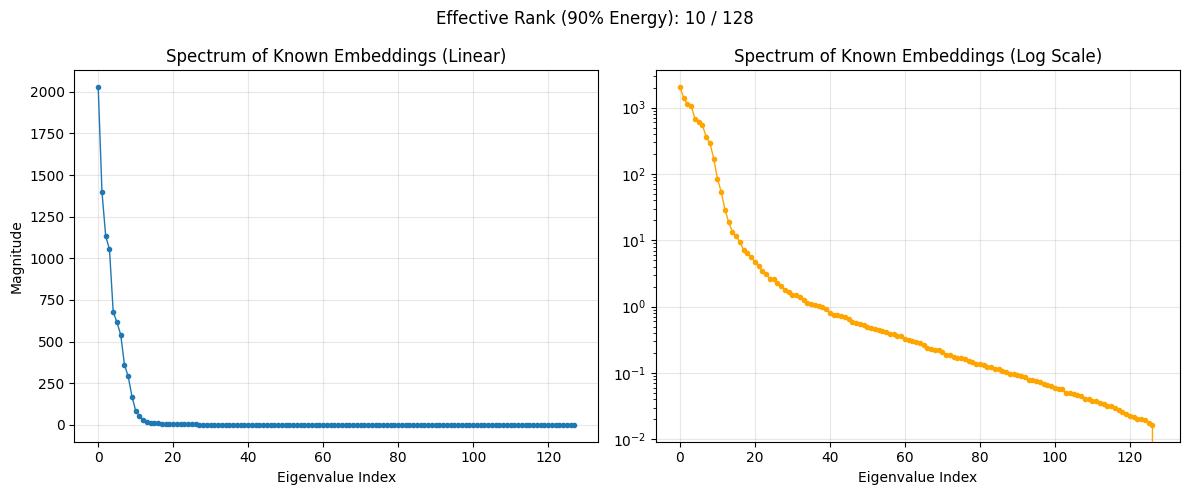

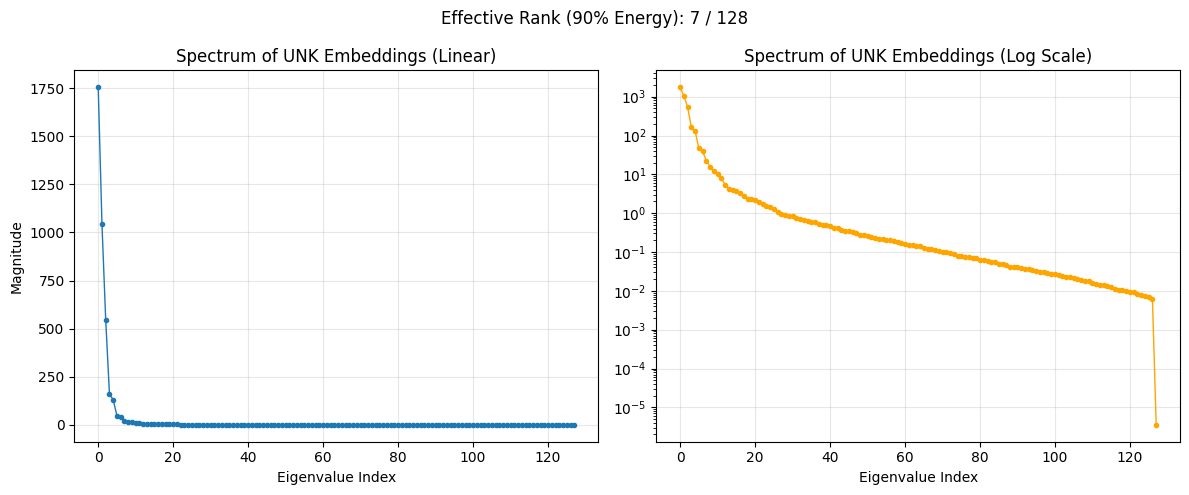

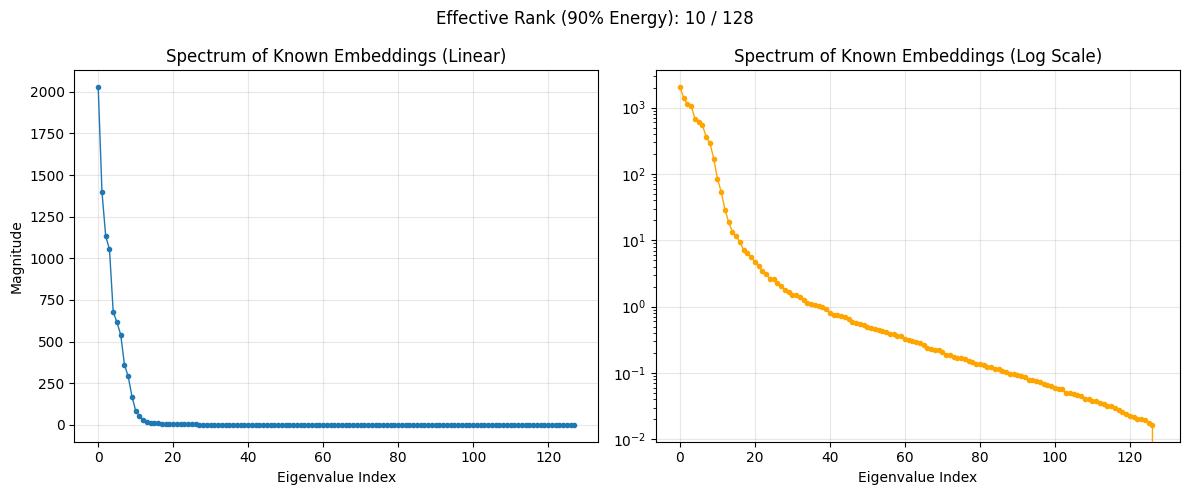

In [64]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image

def analyze_ssm_spectrum(embeddings, mask=None, title="Eigenvalue Spectrum"):
    with torch.no_grad():
        if mask is not None:
            if mask.dim() > 1: mask = mask.reshape(-1)
            if embeddings.dim() > 2: embeddings = embeddings.reshape(-1, embeddings.shape[-1])
            x = embeddings[mask]
        else:
            if embeddings.dim() > 2: x = embeddings.reshape(-1, embeddings.shape[-1])
            else: x = embeddings

        if x.size(0) == 0: return None

        # Normalisieren
        x = F.normalize(x, p=2, dim=-1)

        # X^T * X (Gram Matrix)
        cov_matrix = torch.matmul(x.T, x)

        # Eigenwerte
        eigenvalues = torch.linalg.eigvalsh(cov_matrix)
        eigenvalues = eigenvalues.flip(0) 
        
        evals_np = eigenvalues.cpu().numpy()
        
        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Linear
        ax1.plot(evals_np, 'o-', markersize=3, linewidth=1)
        ax1.set_title(f"{title} (Linear)")
        ax1.set_xlabel("Eigenvalue Index")
        ax1.set_ylabel("Magnitude")
        ax1.grid(True, alpha=0.3)

        # Log
        ax2.semilogy(evals_np + 1e-9, 'o-', markersize=3, linewidth=1, color='orange')
        ax2.set_title(f"{title} (Log Scale)")
        ax2.set_xlabel("Eigenvalue Index")
        ax2.grid(True, alpha=0.3)
        
        total_energy = np.sum(evals_np)
        cumsum = np.cumsum(evals_np)
        dim_90 = np.argmax(cumsum >= 0.96 * total_energy) + 1
        
        fig.suptitle(f"Effective Rank (90% Energy): {dim_90} / {len(evals_np)}")
        plt.tight_layout()
        
        return fig
# --- BEISPIEL INTEGRATION IN DEINEN TRAINER ---
# Füge das z.B. in deine eval() loop oder am Ende einer Epoche ein:

# Angenommen 'result' kommt aus dem Model und 'batch' sind die Daten
# features = result["embeddings"] # Shape [B, T, D]
# mask = batch["known_mask"]      # Shape [B, T]

iterator = iter(data_loader_train)
b_train1 = next(iterator)
b_train2 = next(iterator)
b_train3 = next(iterator)

used = b_train3
model.eval()
model.to("cuda")

known_mask = used["unknown_mask"]
features = used["features"][known_mask].to("cuda").unsqueeze(0)
padding_mask =  used["padding_mask"][known_mask].to("cuda").unsqueeze(0)

out_train = model(features, padding_mask)
print(features.shape)

analyze_ssm_spectrum(out_train["embeddings"][0], None, title="Spectrum of UNK Embeddings")

used = b_train3

i = 500
known_mask = ~used["unknown_mask"]
features = used["features"][known_mask].to("cuda").unsqueeze(0)
print(features.shape)
padding_mask =  used["padding_mask"][known_mask].to("cuda").unsqueeze(0)

out_train = model(features, padding_mask)

analyze_ssm_spectrum(out_train["embeddings"][0], None, title="Spectrum of Known Embeddings")

# wandb.log({"spectral_analysis/eigenvalues": wandb.Image(img)})

/tmp/ipykernel_1994/2315861732.py:81: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(lags_u, corrs_u, 'o-', label='Unknowns', color='orange', linewidth=2, linestyle='--')


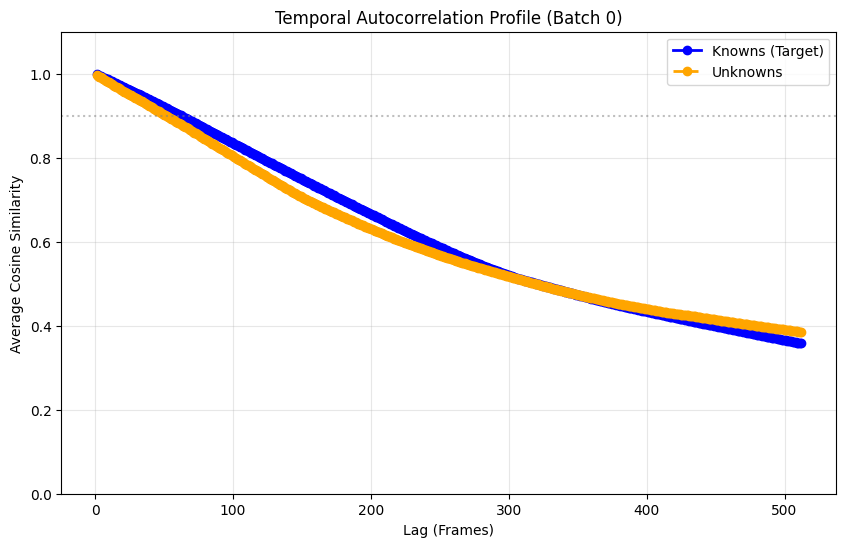

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def calc_lag_profile(embeddings, max_lag=20):
    """
    Berechnet die durchschnittliche Cosine-Similarity für Lags 1 bis max_lag.
    """
    # 1. Normalisieren (Wichtig für Cosine Sim)
    # Input Shape: [N, D]
    if embeddings.dim() == 3: 
        embeddings = embeddings.squeeze(0) # Falls [1, N, D] -> [N, D]
        
    x = F.normalize(embeddings, p=2, dim=-1)
    T = x.size(0)
    
    lags = []
    correlations = []
    
    # Lag 0 ist immer 1.0, wir starten bei 1
    for lag in range(1, max_lag + 1):
        if T > lag:
            # Vektor t und Vektor t+lag vergleichen
            # (x[:-lag] sind Frames 0 bis T-lag)
            # (x[lag:]  sind Frames lag bis T)
            sim = (x[:-lag] * x[lag:]).sum(dim=-1).mean().item()
            
            lags.append(lag)
            correlations.append(sim)
            
    return lags, correlations

# --- 1. DATEN VORBEREITEN ---
iterator = iter(data_loader_train) # oder dein data_loader
b_train1 = next(iterator)
b_train2 = next(iterator)
b_train3 = next(iterator)

used = b_train1
model.eval()
model.to("cuda")

# Wir nehmen das GANZE Video (mit Padding Mask), nicht nur Knowns vorab filtern,
# damit wir Kontext haben.
features = used["features"].to("cuda")     # [B, T, D]
padding_mask = used["padding_mask"].to("cuda") # [B, T]
unknown_mask = used["unknown_mask"].to("cuda") # [B, T]
known_mask = (~unknown_mask) & padding_mask    # [B, T] (Nur echte Known Frames)
valid_unknown_mask = unknown_mask & padding_mask # [B, T] (Nur echte Unk Frames)

# --- 2. MODELL LAUFEN LASSEN ---
with torch.no_grad():
    # Model forward pass auf ganzem Video
    out_train = model(features, padding_mask)
    embeddings = out_train["embeddings"] # [B, T, D]

# --- 3. AUFTEILEN IN KNOWN / UNKNOWN ---
# Wir flachen den Batch ab, falls B > 1
emb_known = embeddings[known_mask] # [N_known, D]
emb_unk = embeddings[valid_unknown_mask] # [N_unk, D]

# --- 4. PROFILE BERECHNEN ---
max_lag = 512
lags_k, corrs_k = calc_lag_profile(emb_known, max_lag=max_lag)

# Nur berechnen, wenn Unknowns da sind
if emb_unk.size(0) > max_lag:
    lags_u, corrs_u = calc_lag_profile(emb_unk, max_lag=max_lag)
else:
    lags_u, corrs_u = [], []

# --- 5. PLOTTEN ---
plt.figure(figsize=(10, 6))

# Plot Knowns (Sollte eine glatte, hohe Kurve sein)
plt.plot(lags_k, corrs_k, 'o-', label='Knowns (Target)', color='blue', linewidth=2)

# Plot Unknowns (Ist aktuell wahrscheinlich ein Zick-Zack oder fällt schnell ab)
if lags_u:
    plt.plot(lags_u, corrs_u, 'o-', label='Unknowns', color='orange', linewidth=2, linestyle='--')

plt.title(f"Temporal Autocorrelation Profile (Batch 0)")
plt.xlabel("Lag (Frames)")
plt.ylabel("Average Cosine Similarity")
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)
plt.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5) # Referenzlinie
plt.legend()

plt.show()